En esta actividad se trabajó con la base de datos CA2022_Cultivos_Superficie_Produccion.csv, proveniente del Censo Agropecuario 2022 (INEGI). Esta base contiene información sobre las unidades de producción agropecuarias y las superficies cultivadas bajo distintos sistemas de riego en México.

El objetivo fue preparar esta base para aplicar dos metodologías de clasificación: Linear Discriminant Analysis (LDA) y Árboles de Decisión podados, con el fin de predecir el número de Unidades de Producción Agropecuaria Activas (UP activas), categorizadas en altas o bajas según la mediana de la distribución.

Para ello, se realizó un proceso de limpieza y depuración de los datos que incluyó:

- Eliminación de columnas no relevantes (NOM_MUN, NOMBRE, ENTIDAD).

- Eliminación de valores nulos en la variable objetivo.

- Tratamiento de outliers con el método de Tukey, para reducir la influencia de valores extremos.

- Eliminación de colinealidad alta entre variables (correlaciones > 0.85).

- Creación de una variable binaria target_bin:

0 (bajo): municipios con menos UP activas que la mediana.

1 (alto): municipios con más UP activas que la mediana.

De esta manera, se obtuvo un dataset limpio y balanceado, listo para dividirse en entrenamiento y prueba, y posteriormente aplicar los modelos de clasificación.

In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv("CA2022_Cultivos_Superficie_Produccion.csv", encoding="latin-1")

# Eliminar columnas no necesarias
df = df.drop(columns=["NOM_MUN", "NOMBRE", "ENTIDAD"], errors="ignore")
target = "Total UP agropecuaria activas"
df = df.dropna(subset=[target])

#  Outliers (Tukey) 
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR
df_tukey = df[(df[target] >= lim_inf) & (df[target] <= lim_sup)].copy()

# Colinealidad
base = df_tukey if 'df_tukey' in globals() else df
y = base[target].copy()
cols_excluir = {target, "UP Agricolas", "y_winz", "y_log", "es_outlier"} & set(base.columns)
X = (
    base.drop(columns=list(cols_excluir), errors="ignore")
        .select_dtypes(include="number")
        .copy()
)
#  Eliminar colinealidad alta 
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
X = X.drop(columns=to_drop, errors="ignore")

df_final = X.copy()
df_final[target] = y

# Convertir variable objetivo a binaria (alto / bajo)
df_final["target_bin"] = (df_final[target] > df_final[target].median()).astype(int)

df_final.head(15)

,UP Argri Riego ( R ),P UP Riego,UP Riego Gravedad (RG),UP RG Canales revestidos,UP RG Canales de Tierra,UP RG Tubería De Compuerta,UP R Por Microaspersión,UP R Por Aspersión,UP R Por Aspersión Pivote Central,UP R Por Aspersión Avance Frontal,UP R Por Aspersión Cañón,UP R Por Aspersores,UP R Sistema De Goteo,UP R Mediante Algún Otro Sistema,Total UP agropecuaria activas,target_bin
1,629.0,56.756757,59.943978,8.411215,22.429907,78.037383,10.364146,37.815126,28.148148,4.444444,18.518519,62.222222,14.565826,0.280112,3098.0,1
2,1033.0,75.217812,45.173745,3.418803,21.367521,79.487179,5.276705,8.365508,9.230769,1.538462,9.230769,89.230769,63.835264,0.128700,3302.0,1
3,1524.0,57.611549,43.735763,3.125000,56.510417,48.177083,27.904328,35.876993,1.269841,0.317460,10.158730,91.428571,11.617312,4.669704,2659.0,1
4,663.0,66.515837,83.219955,28.337875,18.801090,70.299728,0.907029,3.174603,14.285714,0.000000,7.142857,78.571429,32.426304,0.680272,1049.0,1
5,589.0,60.611205,75.630252,8.148148,37.037037,62.962963,2.801120,14.005602,10.000000,0.000000,16.000000,76.000000,10.644258,7.563025,1451.0,1
6,582.0,68.384880,42.462312,5.917160,17.159763,81.065089,5.276382,16.331658,20.000000,1.538462,3.076923,86.153846,65.577889,0.502513,989.0,1
7,932.0,64.914163,53.719008,3.692308,36.615385,73.230769,3.801653,5.123967,16.129032,9.677419,0.000000,83.870968,63.140496,0.661157,1709.0,1
8,264.0,73.863636,95.897436,74.866310,24.598930,49.197861,3.589744,5.641026,0.000000,0.000000,54.545455,54.545455,4.102564,0.000000,1060.0,1
9,704.0,69.318182,69.877049,24.340176,20.527859,78.299120,2.663934,8.811475,0.000000,6.976744,0.000000,95.348837,41.393443,1.024590,1586.0,1
10,317.0,74.763407,90.295359,1.869159,5.607477,94.392523,1.265823,5.063291,58.333333,8.333333,25.000000,25.000000,9.282700,0.421941,2199.0,1


1. Se realizó la división de datos (train/test).  
   Una vez obtenida la base depurada (`df_final`), se definió la variable objetivo (`target_bin`) y se dividieron los datos en conjuntos de entrenamiento (70%) y prueba (30%), utilizando `stratify=y` en `train_test_split`.  
   Esto aseguró que se mantuviera el mismo balance de clases (0 = bajo, 1 = alto) en ambos conjuntos, evitando sesgos durante el entrenamiento y la evaluación.  
   También se imprimieron las proporciones de las clases en el dataset global, train y test, confirmando que se preservaba la distribución.


In [26]:
from sklearn.model_selection import train_test_split

X = df_final.drop([target, "target_bin"], axis=1, errors="ignore")
y = df_final["target_bin"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Revisamos observaciones y proporciones
print("Observaciones en DF")
print(y.value_counts())
print("Proporción en DF")
print(y.value_counts()/y.shape[0])

print("\nObservaciones en Y train")
print(y_train.value_counts())
print("Proporción en Y train")
print(y_train.value_counts()/y_train.shape[0])

print("\nObservaciones en Y test")
print(y_test.value_counts())
print("Proporción en Y test")
print(y_test.value_counts()/y_test.shape[0])

Observaciones en DF
target_bin
1    1151
0    1151
Name: count, dtype: int64
Proporción en DF
target_bin
1    0.5
0    0.5
Name: count, dtype: float64

Observaciones en Y train
target_bin
1    806
0    805
Name: count, dtype: int64
Proporción en Y train
target_bin
1    0.50031
0    0.49969
Name: count, dtype: float64

Observaciones en Y test
target_bin
0    346
1    345
Name: count, dtype: int64
Proporción en Y test
target_bin
0    0.500724
1    0.499276
Name: count, dtype: float64


2. Se ajustó un GLM (Generalized Linear Model) con familia Binomial usando `statsmodels`.  
   Este modelo de regresión logística permitió calcular los coeficientes y p-values de todas las variables predictoras.  
   El criterio para seleccionar variables fue elegir aquellas con los p-values más bajos, ya que indican mayor relevancia estadística para explicar la variable objetivo.  

   Finalmente, se seleccionaron dos variables más significativas:  
   - UP Argri Riego (R)  
   - UP R Por Aspersores  


   El dataset se redujo a estas dos columnas, que serían usadas en los modelos posteriores (LDA y Árbol de decisión). 

In [27]:
import statsmodels.api as sm

# Agregamos la constante
X_train_sm = sm.add_constant(X_train)

# Ajustamos el modelo GLM con familia Binomial
model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
result = model.fit()

# Resumen del modelo
print(result.summary())

# Selección automática de las 2 variables más relevantes (p-values más bajos)
pvals = result.pvalues.drop("const", errors="ignore")
top2 = pvals.sort_values().index[:2].tolist()
print("\nVariables seleccionadas:", top2)

# Reducimos train/test solo a esas 2 variables
X_train_sel = X_train[top2].copy()
X_test_sel  = X_test[top2].copy()

                 Generalized Linear Model Regression Results                  
Dep. Variable:             target_bin   No. Observations:                 1611
Model:                            GLM   Df Residuals:                     1596
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -894.81
Date:                Thu, 02 Oct 2025   Deviance:                       1789.6
Time:                        04:36:23   Pearson chi2:                 1.49e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2407
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

3. Se aplicó un modelo LDA (Linear Discriminant Analysis).  
   LDA busca proyectar los datos en un eje lineal que maximice la separación entre clases.  
   Para evitar distorsiones por las distintas escalas de las variables, se aplicó una estandarización con `StandardScaler`.  
   Posteriormente se generó una malla de puntos en el plano de las dos variables seleccionadas, se predijo la clase en cada punto y se graficó la frontera de decisión lineal (línea negra), junto con las observaciones reales.  

   El modelo alcanzó una exactitud aproximada de 0.65 en entrenamiento y prueba, mostrando un rendimiento aceptable y sin sobreajuste.

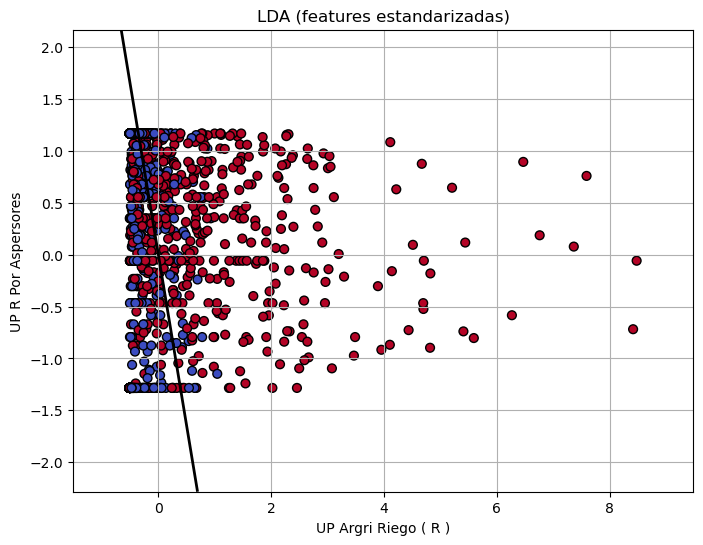

Accuracy LDA - Train: 0.6654252017380509
Accuracy LDA - Test : 0.6468885672937771


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sc2 = StandardScaler()
X_train_2 = pd.DataFrame(sc2.fit_transform(X_train_sel), columns=X_train_sel.columns, index=X_train_sel.index)
X_test_2  = pd.DataFrame(sc2.transform(X_test_sel),  columns=X_test_sel.columns,  index=X_test_sel.index)

lda = LDA().fit(X_train_2, y_train)

v1, v2 = X_train_2.columns
x_min, x_max = X_train_2[v1].min()-1, X_train_2[v1].max()+1
y_min, y_max = X_train_2[v2].min()-1, X_train_2[v2].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
malla_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[v1, v2])
Z = lda.predict_proba(malla_df)[:,1].reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
plt.scatter(X_train_2[v1], X_train_2[v2], c=y_train, edgecolor="k", s=40, cmap="coolwarm")
plt.xlabel(v1); plt.ylabel(v2); plt.title("LDA (features estandarizadas)")
plt.grid(True); plt.show()

print("Accuracy LDA - Train:", lda.score(X_train_2, y_train))
print("Accuracy LDA - Test :", lda.score(X_test_2, y_test))

4. Se implementó un modelo de Árbol de Decisión con poda.  
   Inicialmente se intentó usar validación cruzada tipo LOOCV (Leave-One-Out), pero el proceso tardaba demasiado (más de 10 minutos sin avanzar).  
   Por ello, se optó por una alternativa más eficiente: validación cruzada con K-Fold (cv=5).  
   - Se probaron distintos valores de `ccp_alpha`.  
   - Se eligió el que maximizó la exactitud promedio.  
   - Se podó el árbol de acuerdo con este alpha.  

   Con el árbol podado se visualizaron:  
   - La estructura del árbol con `plot_tree`.  
   - Las particiones en el plano 2D de las dos variables, mostrando cómo el modelo separa las regiones de decisión.  

   El árbol alcanzó también una exactitud cercana a 0.65 en test, con resultados muy parecidos al LDA.

Mejor alpha: 0.0034589487491129395


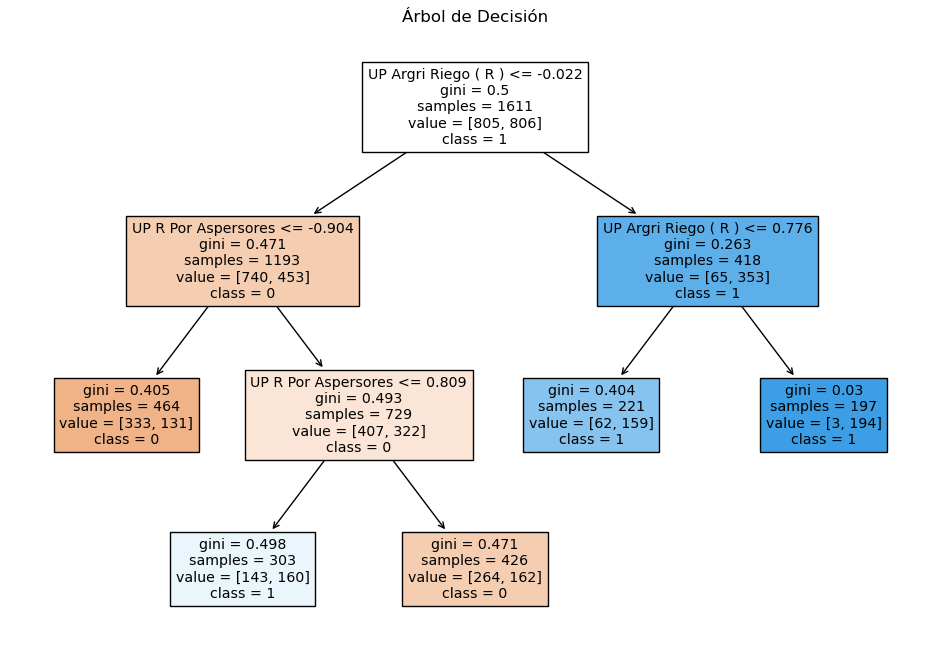

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


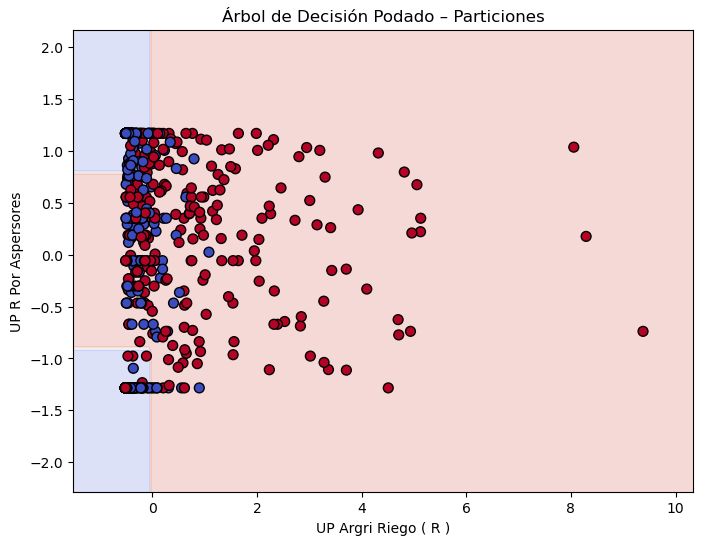

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, cross_val_score

selected_vars = list(X_train_sel.columns)
try:
    X_train_2, X_test_2
except NameError:
    from sklearn.preprocessing import StandardScaler
    sc2 = StandardScaler()
    X_train_2 = pd.DataFrame(sc2.fit_transform(X_train_sel), columns=selected_vars, index=X_train_sel.index)
    X_test_2  = pd.DataFrame(sc2.transform(X_test_sel),  columns=selected_vars, index=X_test_sel.index)


# 1) Búsqueda de alpha óptimo (rápida)
base = DecisionTreeClassifier(random_state=42)
path = base.cost_complexity_pruning_path(X_train_2, y_train)
ccp_alphas = np.unique(path.ccp_alphas)

if len(ccp_alphas) > 25:
    ccp_alphas = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 25)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for a in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    scores.append(cross_val_score(tree, X_train_2, y_train, cv=cv, scoring="accuracy").mean())
best_alpha = ccp_alphas[int(np.argmax(scores))]
print("Mejor alpha:", best_alpha)

# 2) Entrenar árbol podado y graficar estructura
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
tree.fit(X_train_2, y_train)
plt.figure(figsize=(12,8))
plot_tree(tree, feature_names=selected_vars, class_names=["0","1"], filled=True)
plt.title("Árbol de Decisión")
plt.show()

# 3) Visualizar partición
var1, var2 = selected_vars[0], selected_vars[1]
x_min, x_max = X_test_2[var1].min()-1, X_test_2[var1].max()+1
y_min, y_max = X_test_2[var2].min()-1, X_test_2[var2].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.20, cmap="coolwarm")
plt.scatter(X_test_2[var1], X_test_2[var2], c=y_test, edgecolors="k", s=50, cmap="coolwarm")
plt.xlabel(var1)
plt.ylabel(var2)
plt.title("Árbol de Decisión Podado – Particiones")
plt.show()

5. Se realizó la evaluación de métricas para ambos modelos.  
   Se utilizaron las siguientes métricas:  
   - Accuracy (exactitud)  
   - Precision  
   - Recall  
   - F1 Score  
   - AUC (Área bajo la curva)  
   - Matrices de confusión  

   Se programó una función para graficar la matriz de confusión, asegurando que incluso los valores 0 aparecieran en pantalla.  
   Los resultados mostraron que tanto LDA como el Árbol podado obtuvieron un rendimiento muy similar (~0.65 de accuracy en test).  
   La principal diferencia estuvo en la interpretabilidad:  
   - LDA ofreció una frontera lineal más simple.  
   - El Árbol proporcionó reglas claras basadas en umbrales de las variables.



=== LDA ===
Accuracy : 0.647
Precision: 0.735
Recall   : 0.458
F1       : 0.564
ROC_AUC  : 0.705

Reporte de clasificación:
              precision    recall  f1-score   support

        Bajo       0.61      0.84      0.70       346
        Alto       0.73      0.46      0.56       345

    accuracy                           0.65       691
   macro avg       0.67      0.65      0.63       691
weighted avg       0.67      0.65      0.63       691


=== Árbol de Decisión ===
Accuracy : 0.651
Precision: 0.658
Recall   : 0.629
F1       : 0.643
ROC_AUC  : 0.708

Reporte de clasificación:
              precision    recall  f1-score   support

        Bajo       0.65      0.67      0.66       346
        Alto       0.66      0.63      0.64       345

    accuracy                           0.65       691
   macro avg       0.65      0.65      0.65       691
weighted avg       0.65      0.65      0.65       691



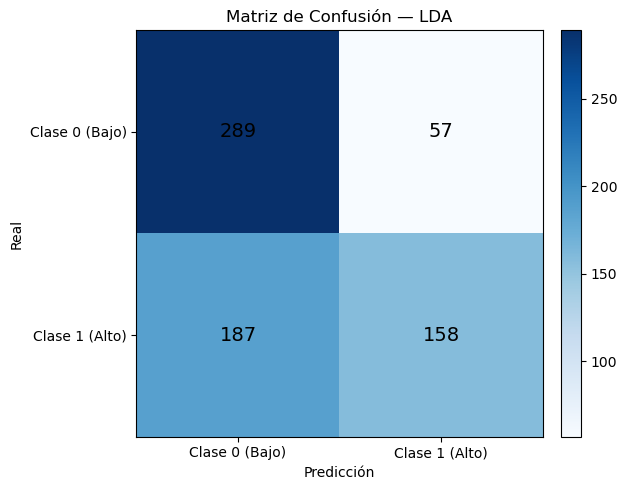

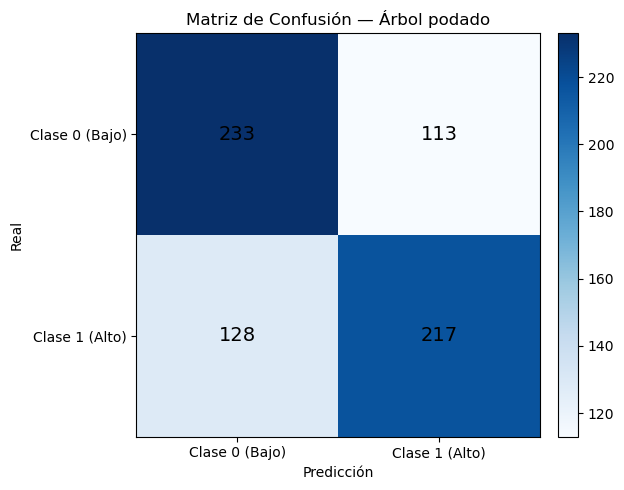

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

def eval_model(nombre, modelo, Xte, yte):
    y_pred = modelo.predict(Xte)
    out = {
        "Modelo": nombre,
        "Accuracy": accuracy_score(yte, y_pred),
        "Precision": precision_score(yte, y_pred, zero_division=0),
        "Recall": recall_score(yte, y_pred, zero_division=0),
        "F1": f1_score(yte, y_pred, zero_division=0),
    }
    try:
        y_prob = modelo.predict_proba(Xte)[:, 1]
        out["ROC_AUC"] = roc_auc_score(yte, y_prob)
    except Exception:
        out["ROC_AUC"] = roc_auc_score(yte, y_pred)
    print(f"\n=== {nombre} ===")
    for k,v in out.items():
        if k != "Modelo":
            print(f"{k:9s}: {v:.3f}")
    print("\nReporte de clasificación:")
    print(classification_report(yte, y_pred, target_names=["Bajo","Alto"], zero_division=0))
    return y_pred

def plot_confusion(y_true, y_pred, titulo="Matriz de confusión"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(titulo)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks); ax.set_xticklabels(["Clase 0 (Bajo)","Clase 1 (Alto)"])
    ax.set_yticks(tick_marks); ax.set_yticklabels(["Clase 0 (Bajo)","Clase 1 (Alto)"])
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(int(cm[i, j])),
                    ha="center", va="center", color="black", fontsize=14)
    fig.tight_layout()
    plt.show()

y_pred_lda  = eval_model("LDA",               lda,  X_test_2, y_test)
y_pred_tree = eval_model("Árbol de Decisión", tree, X_test_2, y_test)

# Matrices de confusión
plot_confusion(y_test, y_pred_lda,  "Matriz de Confusión — LDA")
plot_confusion(y_test, y_pred_tree, "Matriz de Confusión — Árbol podado")


Tras aplicar y evaluar los modelos de Linear Discriminant Analysis (LDA) y Árbol de Decisión podado sobre el conjunto de datos agropecuarios, se observa que ambos alcanzaron un rendimiento global similar en términos de exactitud, con valores cercanos al 65% en el conjunto de prueba. Esto indica que en promedio ambos algoritmos logran clasificar de manera correcta a dos de cada tres observaciones.

Sin embargo, al analizar métricas adicionales y las matrices de confusión, se aprecia un comportamiento distinto en cada modelo:

- El LDA mostró una precisión más alta para la clase “Alto” (0.73), lo que significa que cuando predice un municipio como de alta actividad agropecuaria suele acertar. No obstante, su recall bajo (0.46) refleja que deja escapar una gran cantidad de casos que en realidad pertenecían a esta categoría, priorizando la detección de la clase “Bajo”.

- El Árbol de Decisión podado, en contraste, logró un balance más adecuado entre precisión y recall (ambos alrededor de 0.63–0.66). Esto le permitió identificar un mayor número de municipios con alta actividad (217 vs. 158 detectados por LDA), aun si sacrificó algunos aciertos en la clase “Bajo”. Además, presentó un mejor desempeño en F1 Score (0.643 vs. 0.564) y un AUC ligeramente superior (0.708 vs. 0.705), lo que respalda su mayor capacidad de clasificación equilibrada.

Otro aspecto a resaltar es la interpretabilidad: mientras que el LDA se limita a una frontera lineal entre las clases, el árbol podado ofrece reglas claras basadas en umbrales de las variables seleccionadas, lo que facilita su comprensión y aplicación en contextos prácticos (ejemplo: “si el número de unidades con riego es menor a cierto valor, clasificar como bajo”). Además, en términos de eficiencia computacional, la implementación con poda mediante K-Fold fue mucho más viable que el método inicial de LOOCV, que resultaba demasiado costoso en tiempo de ejecución.

En conclusión, aunque ambos modelos obtuvieron rendimientos globales similares, el Árbol de Decisión podado resulta más adecuado para esta tarea específica, ya que combina una capacidad de clasificación equilibrada entre las dos clases, métricas ligeramente superiores y una mayor interpretabilidad. Esto lo convierte en una herramienta más confiable y útil para la identificación de municipios con alta o baja actividad agropecuaria dentro del dataset.